<a href="https://colab.research.google.com/github/jinseo347/project-A/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
! pip install klib

In [ ]:
# ! pip install --upgrade pandas

In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PowerTransformer
# from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# import numpy as np
# import pandas as pd 

# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# plt.rc('font', family='NanumBarunGothic') 

# data

In [ ]:
df = pd.read_excel('/content/credit_card_pay.xlsx')

In [ ]:
# klib.dist_plot(df)

In [ ]:
klib.corr_plot(df, target='default payment next month')
klib.corr_plot(df, annot=False, figsize=(15,12))
klib.corr_plot(df, split='high', annot=False, figsize=(15,12))

# origin_df 모델링


In [ ]:
train = df.drop(['ID', 'default payment next month'], axis=1)
test = df['default payment next month']

In [ ]:
train.shape , test.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, 
                                                    test, 
                                                    test_size = 0.2)

In [ ]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': ['auto', 32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [None,3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'loss' : ["deviance"],
         'n_estimators' : [100],
         'learning_rate': [0.1, 0.05, 0.01],
         'max_depth': [4],
         'min_samples_leaf': [100,150],
         'max_features': [0.3, 0.1]}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        AdaBoostClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01]}
    ), 
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
          'max_depth': [None,3,4,5]}
    ),
     (
        XGBClassifier(random_state=0),
        {'min_child_weight' : [1],
         'n_estimators' : [250],
         'learning_rate': [0.07],
         'max_depth': [3, 4],
         'reg_alpha': [0,0.01]}
    )
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_test, y_test)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))
    clfs_tuned.append((clf_name, rand_search, clf_score))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
scaled_clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_test_scaled, y_test)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))
    scaled_clfs_tuned.append((clf_name, rand_search, clf_score))

In [ ]:
klib.corr_plot(X_train, target=y_train)
klib.corr_plot(X_train, target=y_train, annot=False, figsize=(15,12))
klib.corr_plot(X_train, target=y_train, split='high', annot=False, figsize=(15,12))

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

In [ ]:
X_train.isnull().sum()

In [ ]:
# origin data XGBClassifier모델
# 100%|██████████| 8/8 [07:36<00:00, 57.08s/it]XGBClassifier                                        0.789065 81.5
# 최적 하이퍼 파라미터:  {'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.07}
# 최고 예측 정확도: 0.7793

XGBC = XGBClassifier(reg_alpha=0, n_estimators=250, min_child_weight=1,
                     max_depth=3, learning_rate=0.07, random_state=42)
XGBC.fit(X_train, y_train)

# ▶ 예측
y_pred_train = XGBC.predict(X_train)
y_pred_test = XGBC.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# scaled data AdaBoostClassifier모델
#  75%|███████▌  | 6/8 [05:44<02:14, 67.26s/it]AdaBoostClassifier                                   0.740279 114.1
# 최적 하이퍼 파라미터:  {'n_estimators': 200, 'learning_rate': 0.1}

abc = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
abc.fit(X_train_scaled, y_train)

# ▶ 예측
y_pred_train = abc.predict(X_train_scaled)
y_pred_test = abc.predict(X_test_scaled)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# origin data RandomForestClassifier모델
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# scaled data RandomForestClassifier모델
scaled_rfc = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
scaled_rfc.fit(X_train_scaled, y_train)

# ▶ 예측
y_pred_train = scaled_rfc.predict(X_train_scaled)
y_pred_test = scaled_rfc.predict(X_test_scaled)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
ftr_importances_values = scaled_rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('scaled_RandomForestClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('RandomForestClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = abc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('AdaBoostClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = XGBC.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('XGBClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

# 기존 feature engineering

## IMIT_BAL

In [ ]:
# (1->50000 이하, 2->140000 이하, 3->240000 이하, 4->240000 이상)
df['LIMIT_BAL_GP'] = np.where (df['LIMIT_BAL'] <= 50000, 1, 
                           np.where(df['LIMIT_BAL'] <= 140000, 2,
                           np.where(df['LIMIT_BAL'] <= 240000, 3, 4)))
df.LIMIT_BAL_GP.value_counts(), sorted(df.LIMIT_BAL_GP.unique()), len(df.LIMIT_BAL_GP.unique())

### 시각화

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='default payment next month', hue=df['LIMIT_BAL_GP'], data=df, dodge=True, palette="pastel");

## EDUCATION

In [ ]:
# (1-대학원, 2-대학교, 3-고등학교, 4-기타)
df['EDUCATION_re'] = np.where ((0 < df['EDUCATION']) & (df['EDUCATION'] <= 3), df['EDUCATION'], 4)
df.EDUCATION_re.value_counts(), sorted(df.EDUCATION_re.unique()), len(df.EDUCATION_re.unique())

### 시각화

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='default payment next month', hue=df['EDUCATION_re'], data=df, dodge=True, palette="pastel");

## MARRIAGE

In [ ]:
# (1-기혼, 2-미혼, 3-기타)
df['MARRIAGE_re'] = np.where ((0 < df['MARRIAGE']) & (df['MARRIAGE'] <= 3), df['MARRIAGE'], 3)
df.MARRIAGE_re.value_counts(), sorted(df.MARRIAGE_re.unique()), len(df.MARRIAGE_re.unique())

### 시각화

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='default payment next month', hue=df['MARRIAGE_re'], data=df, dodge=True, palette="pastel");

## AGE

In [ ]:
# (1-20대, 2-30대, 3-55세이하, 4-55세이상)

df['AGE_GP'] = np.where (df['AGE'] <= 30, 1, 
                           np.where(df['AGE'] <= 40, 2,
                           np.where(df['AGE'] <= 55, 3, 4)))
df.AGE_GP.value_counts(), sorted(df.AGE_GP.unique()), len(df.AGE_GP.unique())

In [ ]:
df['AGE'].describe()

In [ ]:
df['AGE_GP_Q'] = np.where (df['AGE'] <= 28, 1, 
                           np.where(df['AGE'] <= 34, 2,
                           np.where(df['AGE'] <= 41, 3, 4)))
df.AGE_GP_Q.value_counts(), sorted(df.AGE_GP_Q.unique()), len(df.AGE_GP_Q.unique())

### 시각화

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='default payment next month', hue=df['AGE_GP'], data=df, dodge=True, palette="pastel");

In [ ]:
sns.countplot(x='default payment next month', hue=df['AGE_GP_Q'], data=df, dodge=True, palette="pastel");

# orin Corr()

In [ ]:
col_name = df.columns
df_corr_li = []
for idx in range(len(col_name)):
  df_corr_li.append(df[col_name[idx]].corr(df['default payment next month']))

  # print(name, df[name].corr(df['default payment next month'])
df_corr = pd.DataFrame(df_corr_li, col_name)

In [ ]:
df_corr.columns = ['corr']

In [ ]:
df_corr['abs_corr'] = abs(df_corr['corr'])

In [ ]:
df_corr.sort_values(by='abs_corr', ascending=False)

# New Feature

## 0_count

청구 금액이 0원인 달의 수 

가설 = 카드를 사용하지 않는 고객일수록 default일 것 이다.

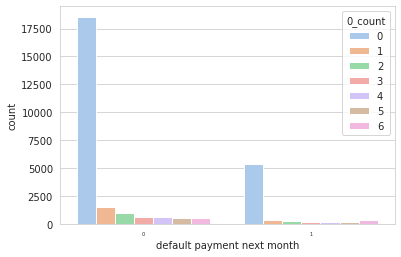

연관 없음

In [ ]:
df_bill_amt = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
df_bill_amt

from collections import Counter
df['0_count'] = df['BILL_AMT1']

for idx in range(df.shape[0]):
  df['0_count'][idx] = Counter(df_bill_amt.iloc[idx])[0]

### 시각화

In [ ]:
sns.countplot(x='default payment next month', hue=df['0_count'], data=df, dodge=True, palette="pastel");

In [ ]:
df['0_count'].corr(df['default payment next month'])

## delay (PAY_avg)

-2, -1, 0 을 0으로 통합 ( 지연되지않은 값으로 처리)

In [ ]:
df['PAY_0'] = np.where((df['PAY_0']<=0), 0, df['PAY_0'])
df['PAY_2'] = np.where((df['PAY_2']<=0), 0, df['PAY_2'])
df['PAY_3'] = np.where((df['PAY_3']<=0), 0, df['PAY_3'])
df['PAY_4'] = np.where((df['PAY_4']<=0), 0, df['PAY_4'])
df['PAY_5'] = np.where((df['PAY_5']<=0), 0, df['PAY_5'])
df['PAY_6'] = np.where((df['PAY_6']<=0), 0, df['PAY_6'])

In [ ]:
df['delay']=(df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6'])/6

In [ ]:
df['delay'].describe()

In [ ]:
df.sort_values(by='delay', ascending=False)

In [ ]:
df['delay_GP'] = np.where (df['delay'] == 0, 1, 
                           np.where(df['delay'] <= 0.2, 2,
                           np.where(df['delay'] <= 0.4, 3, 4)))
df.delay_GP.value_counts(), sorted(df.delay_GP.unique()), len(df.delay_GP.unique())

### 시각화

In [ ]:
sns.countplot(x='default payment next month', hue=df['delay_GP'], data=df, dodge=True, palette="pastel");

In [ ]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.countplot(x='default payment next month', hue=df['delay'], data=df, dodge=True, palette="pastel");

## LIMIT_USE_AVG

신용 한도 대비 청구금액 비율

In [ ]:
df['LIMIT_USE_AVG'] = ((df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'])/6) / df['LIMIT_BAL']

In [ ]:
df['LIMIT_USE_AVG'] 

In [ ]:
df['LIMIT_USE_AVG'].describe() 

In [ ]:
df.sort_values(by='LIMIT_USE_AVG', ascending=False)

### 시각화

In [ ]:
x = df.LIMIT_USE_AVG.values
sns.distplot(x, kde=True, rug=True)
plt.title("LIMIT_USE_AVG Dist Plot")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['default payment next month']==0]['LIMIT_USE_AVG'], label='Good')
sns.kdeplot(df[df['default payment next month']==1]['LIMIT_USE_AVG'], label='Bad')
plt.xlabel('LIMIT_USE_AVG')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.countplot(x='default payment next month', hue=df['delay'], data=df, dodge=True, palette="pastel");

## 지난 달 대비 이번 달 청구금액 증감률

limit balance 그룹별로 증감률의 평균 → 평균보다 높은 사람을 1, 그외 0? 

In [ ]:
df.LIMIT_BAL_GP

In [ ]:
df['BILL_AMT_CHANGE_AVG'] = ((((df['BILL_AMT6'] - df['BILL_AMT5']) / df['BILL_AMT5']) + ((df['BILL_AMT5'] - df['BILL_AMT4']) / df['BILL_AMT4']) + ((df['BILL_AMT4'] - df['BILL_AMT3']) / df['BILL_AMT3']) + ((df['BILL_AMT3'] - df['BILL_AMT2']) / df['BILL_AMT2']) + ((df['BILL_AMT2'] - df['BILL_AMT1']) / df['BILL_AMT1'])) / 5) * 100

In [ ]:
df['BILL_AMT_CHANGE_AVG5'] = ((df['BILL_AMT6'] - df['BILL_AMT5']) / df['BILL_AMT5'])
df['BILL_AMT_CHANGE_AVG4'] = ((df['BILL_AMT5'] - df['BILL_AMT4']) / df['BILL_AMT4'])
df['BILL_AMT_CHANGE_AVG3'] = ((df['BILL_AMT4'] - df['BILL_AMT3']) / df['BILL_AMT3'])
df['BILL_AMT_CHANGE_AVG2'] = ((df['BILL_AMT3'] - df['BILL_AMT2']) / df['BILL_AMT2'])
df['BILL_AMT_CHANGE_AVG1'] = ((df['BILL_AMT2'] - df['BILL_AMT1']) / df['BILL_AMT1'])

In [ ]:
BILL_AMT_CHANGE_AVG_df = df[['BILL_AMT_CHANGE_AVG1', 'BILL_AMT_CHANGE_AVG2', 'BILL_AMT_CHANGE_AVG3', 'BILL_AMT_CHANGE_AVG4', 'BILL_AMT_CHANGE_AVG5']]

In [ ]:
BILL_AMT_CHANGE_AVG_df['total'] = df.sum(axis=1)

In [ ]:
BILL_AMT_CHANGE_AVG_df['total'].describe()

In [ ]:
# nan값 확인 
df['BILL_AMT_CHANGE_AVG'].isnull().sum()

In [ ]:
# nan값 0으로 대체
df['BILL_AMT_CHANGE_AVG'] = df['BILL_AMT_CHANGE_AVG'].fillna(0)

In [ ]:
# nan값 확인 
df['BILL_AMT_CHANGE_AVG'].isnull().sum()

In [ ]:
df['BILL_AMT_CHANGE_AVG'].describe()

In [ ]:
LIMIT_BAL_GP_1 = df[df['LIMIT_BAL_GP'] == 1]['BILL_AMT_CHANGE_AVG']
LIMIT_BAL_GP_2 = df[df['LIMIT_BAL_GP'] == 2]['BILL_AMT_CHANGE_AVG']
LIMIT_BAL_GP_3 = df[df['LIMIT_BAL_GP'] == 3]['BILL_AMT_CHANGE_AVG']
LIMIT_BAL_GP_4 = df[df['LIMIT_BAL_GP'] == 4]['BILL_AMT_CHANGE_AVG']

In [ ]:
LIMIT_BAL_GP_1

In [ ]:
df['LIMIT_BAL_GP'][4]

In [ ]:
# df['BILL_AMT_CHANGE_AVG_GR'] = df['LIMIT_BAL_GP']
# for i in range(30000):
#   if df['LIMIT_BAL_GP'][i] == 1:
#     df['BILL_AMT_CHANGE_AVG_GR'][i] = 


# new Corr()

In [ ]:
col_name = df.columns
df_corr_li = []
for idx in range(len(col_name)):
  df_corr_li.append(df[col_name[idx]].corr(df['default payment next month']))

  # print(name, df[name].corr(df['default payment next month'])
df_corr = pd.DataFrame(df_corr_li, col_name)

In [ ]:
df_corr.columns = ['corr']

In [ ]:
df_corr['abs_corr'] = abs(df_corr['corr'])

In [ ]:
df_corr.sort_values(by='abs_corr', ascending=False)

# choose df 모델링


In [ ]:
choose_train = df[['EDUCATION_re', 'delay', 'LIMIT_USE_AVG', 'LIMIT_BAL_GP', 'AGE_GP']]
test = df['default payment next month']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(choose_train, 
                                                    test, 
                                                    test_size = 0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

In [ ]:
choose_clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_test, y_test)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))
    choose_clfs_tuned.append((clf_name, rand_search, clf_score))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
scaled_choose_clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_test_scaled, y_test)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))
    scaled_clfs_tuned.append((clf_name, rand_search, clf_score))

In [ ]:
klib.corr_plot(X_train, target=y_train)
klib.corr_plot(X_train, target=y_train, annot=False, figsize=(15,12))
klib.corr_plot(X_train, target=y_train, split='high', annot=False, figsize=(15,12))

In [ ]:
X_train.isnull().sum()

In [ ]:
# choose data GradientBoostingClassifier 모델
# 62%|██████▎   | 5/8 [05:12<02:17, 45.88s/it]GradientBoostingClassifier                           0.770011 11.2
# 최적 하이퍼 파라미터:  {'n_estimators': 100, 'min_samples_leaf': 100, 'max_features': 0.1, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.1}
# 최고 예측 정확도: 0.7701

GBC = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=100,
                     max_features=0.1, max_depth=4, loss='deviance', learning_rate=0.07, random_state=42)
GBC.fit(X_train, y_train)

# ▶ 예측
y_pred_train = GBC.predict(X_train)
y_pred_test = GBC.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# scaled data LogisticRegression 모델
#  38%|███▊      | 3/8 [04:48<07:39, 91.95s/it] LogisticRegression                                   0.742516 0.4
# 최적 하이퍼 파라미터:  {'penalty': 'l2', 'C': 1.0}
# 최고 예측 정확도: 0.7429

LR = LogisticRegression(penalty='l2', C=1.0)
LR.fit(X_train_scaled, y_train)

# ▶ 예측
y_pred_train = LR.predict(X_train_scaled)
y_pred_test = LR.predict(X_test_scaled)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# origin data RandomForestClassifier모델
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# scaled data RandomForestClassifier모델
scaled_rfc = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
scaled_rfc.fit(X_train_scaled, y_train)

# ▶ 예측
y_pred_train = scaled_rfc.predict(X_train_scaled)
y_pred_test = scaled_rfc.predict(X_test_scaled)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
ftr_importances_values = scaled_rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('scaled_RandomForestClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('RandomForestClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
# ftr_importances_values = LR.feature_importances_
# ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
# ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

# plt.figure(figsize=(8,6))
# plt.title('AdaBoostClassifier model Feature Importances')
# sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
# plt.rc('xtick', labelsize=5)
# plt.show()

In [ ]:
ftr_importances_values = GBC.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('XGBClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
# origin data XGBClassifier모델
# 100%|██████████| 8/8 [07:36<00:00, 57.08s/it]XGBClassifier                                        0.789065 81.5
# 최적 하이퍼 파라미터:  {'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.07}
# 최고 예측 정확도: 0.7793

XGBC = XGBClassifier(reg_alpha=0, n_estimators=250, min_child_weight=1,
                     max_depth=3, learning_rate=0.07, random_state=42)
XGBC.fit(X_train, y_train)

# ▶ 예측
y_pred_train = XGBC.predict(X_train)
y_pred_test = XGBC.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
# scaled data AdaBoostClassifier모델
#  75%|███████▌  | 6/8 [05:44<02:14, 67.26s/it]AdaBoostClassifier                                   0.740279 114.1
# 최적 하이퍼 파라미터:  {'n_estimators': 200, 'learning_rate': 0.1}

abc = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
abc.fit(X_train_scaled, y_train)

# ▶ 예측
y_pred_train = abc.predict(X_train_scaled)
y_pred_test = abc.predict(X_test_scaled)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

In [ ]:
ftr_importances_values = XGBC.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('XGBClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

In [ ]:
ftr_importances_values = abc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('AdaBoostClassifier model Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()